In [ ]:
# ============================================
# Cell 1: Imports
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True



In [ ]:

# ============================================
# Cell 2: Binary Linear SVM (from scratch)
# ============================================

class LinearSVMGD:
    """
    Binary linear SVM trained with gradient descent on hinge loss:
        0.5 * ||w||^2 + C * sum(max(0, 1 - y_i * (w·x_i + b)))
    y_i must be in {-1, +1}.
    Internally standardizes features (mean/std) and stores support vectors.
    """

    def __init__(self, C=1.0, lr=0.01, n_iters=5000):
        self.C = C
        self.lr = lr
        self.n_iters = n_iters
        self.w_ = None
        self.b_ = None
        self.mean_ = None
        self.scale_ = None
        self.support_vectors_ = None  # in ORIGINAL feature space

    def _standardize(self, X):
        return (X - self.mean_) / self.scale_

    def fit(self, X, y):
        """
        X: (n_samples, n_features) in ORIGINAL space
        y: (n_samples,) with values in {-1, +1}
        """
        n_samples, n_features = X.shape

        # compute mean/std for standardization
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.scale_[self.scale_ == 0] = 1.0  # avoid division by zero

        Xs = self._standardize(X)

        # initialize w, b in standardized space
        self.w_ = np.zeros(n_features)
        self.b_ = 0.0

        for _ in range(self.n_iters):
            margins = y * (Xs @ self.w_ + self.b_)
            indicator = (margins < 1).astype(float)

            grad_w = self.w_ - self.C * (Xs.T @ (y * indicator)) / n_samples
            grad_b = - self.C * np.sum(y * indicator) / n_samples

            self.w_ -= self.lr * grad_w
            self.b_ -= self.lr * grad_b

        # Approximate support vectors as those with margin <= 1 + eps
        margins = y * (Xs @ self.w_ + self.b_)
        sv_mask = margins <= 1.02
        self.support_vectors_ = X[sv_mask]  # original feature space

        return self

    def decision_function(self, X):
        """Raw scores f(x) = w·x + b, X in original space."""
        Xs = (X - self.mean_) / self.scale_
        return Xs @ self.w_ + self.b_

    def predict(self, X):
        scores = self.decision_function(X)
        return np.sign(scores)

    def hyperplane_original(self):
        """
        Convert (w, b) from standardized space into original feature space.

        If x_scaled = (x - mean)/scale and decision = w_scaled·x_scaled + b_scaled,
        then in original coordinates the plane is:

            w_orig·x + b_orig = 0

        with:
            w_orig_j = w_scaled_j / scale_j
            b_orig   = b_scaled - sum_j (w_scaled_j * mean_j / scale_j)
        """
        w_scaled = self.w_
        b_scaled = self.b_

        w_orig = w_scaled / self.scale_
        b_orig = b_scaled - np.sum(w_scaled * self.mean_ / self.scale_)

        return w_orig, b_orig



In [60]:

# ============================================
# Cell 3: Multiclass One-vs-Rest Wrapper
# ============================================

class MultiClassLinearSVM_OVR:
    """
    One-vs-Rest (OvR) multiclass SVM using multiple LinearSVMGD models.
    For each class k:
        y_k = +1 for samples of class k, -1 otherwise
    The predicted class is argmax_k f_k(x), where f_k is that class's decision function.
    """

    def __init__(self, C=1.0, lr=0.01, n_iters=5000):
        self.C = C
        self.lr = lr
        self.n_iters = n_iters
        self.classes_ = None
        self.models_ = {}  # class_label -> LinearSVMGD
        self.support_vectors_ = None  # union of all SVs

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models_ = {}

        all_support_vectors = []

        for cls in self.classes_:
            y_bin = np.where(y == cls, 1, -1)
            model = LinearSVMGD(C=self.C, lr=self.lr, n_iters=self.n_iters)
            model.fit(X, y_bin)
            self.models_[cls] = model
            all_support_vectors.append(model.support_vectors_)

        # union of support vectors (deduplicate rows)
        if all_support_vectors:
            sv = np.vstack(all_support_vectors)
            # deduplicate
            sv_unique = np.unique(sv, axis=0)
            self.support_vectors_ = sv_unique
        else:
            self.support_vectors_ = np.empty((0, X.shape[1]))

        return self

    def decision_function(self, X):
        """
        Returns scores of shape (n_samples, n_classes),
        scores[i, k] = f_k(x_i)
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for idx, cls in enumerate(self.classes_):
            scores[:, idx] = self.models_[cls].decision_function(X)

        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        best_idx = np.argmax(scores, axis=1)
        return self.classes_[best_idx]

    def hyperplanes_original(self):
        """
        Returns a dict: class_label -> (w_orig, b_orig)
        so each class has its one-vs-rest hyperplane in original space.
        """
        planes = {}
        for cls, model in self.models_.items():
            planes[cls] = model.hyperplane_original()
        return planes



In [ ]:

# ============================================
# Cell 4: Configuration (easy dataset swap)
# ============================================

# Path to your CSV dataset
DATA_PATH = "penguins_with_chinstrap.csv"   # <-- change this to your dataset

# Name of the target/label column
TARGET_COL = "species"       # <-- change this to your label column

# Three numeric feature columns for the 3D SVM
FEATURES_3D = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]

# Two numeric feature columns (subset or different) for the 2D SVM
FEATURES_2D = ["bill_length_mm", "flipper_length_mm"]

# OPTIONAL: If you want to restrict to a subset of classes, list them here.
# Leave as None to use ALL classes present.
# Example: CLASS_FILTER = ["Adelie", "Gentoo", "Chinstrap"]
CLASS_FILTER = None



In [62]:

# ============================================
# Cell 5: Load data and prepare train/test
# ============================================

df = pd.read_csv(DATA_PATH)

# Ensure required columns exist
needed_cols = set([TARGET_COL] + FEATURES_3D + FEATURES_2D)
missing = needed_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in dataset: {missing}")

# Drop rows with missing values for the used columns
df = df.dropna(subset=list(needed_cols))

# Optional: restrict to selected classes
if CLASS_FILTER is not None:
    df = df[df[TARGET_COL].isin(CLASS_FILTER)].copy()
    print("Restricting to classes:", df[TARGET_COL].unique().tolist())

# Features and labels
X3 = df[FEATURES_3D].values
X2 = df[FEATURES_2D].values
y = df[TARGET_COL].values

print("Classes in use:", np.unique(y))
print("3D features:", FEATURES_3D)
print("2D features:", FEATURES_2D)

# Manual train/test split (no sklearn)
rng = np.random.default_rng(42)
indices = np.arange(len(df))
rng.shuffle(indices)

test_size = int(0.2 * len(indices))
test_idx = indices[:test_size]
train_idx = indices[test_size:]

X3_train, X3_test = X3[train_idx], X3[test_idx]
X2_train, X2_test = X2[train_idx], X2[test_idx]
y_train, y_test = y[train_idx], y[test_idx]



Classes in use: ['Adelie' 'Gentoo']
3D features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
2D features: ['bill_length_mm', 'flipper_length_mm']


In [63]:

# ============================================
# Cell 6: Train 3D and 2D Multiclass SVMs
# ============================================

svm3d = MultiClassLinearSVM_OVR(C=1.0, lr=0.01, n_iters=5000)
svm3d.fit(X3_train, y_train)

svm2d = MultiClassLinearSVM_OVR(C=1.0, lr=0.01, n_iters=5000)
svm2d.fit(X2_train, y_train)

# Evaluate accuracies
y3_pred_test = svm3d.predict(X3_test)
acc3 = np.mean(y3_pred_test == y_test)

y2_pred_test = svm2d.predict(X2_test)
acc2 = np.mean(y2_pred_test == y_test)

print(f"\n3D OvR SVM (from scratch) accuracy: {acc3:.4f}")
print(f"2D OvR SVM (from scratch) accuracy: {acc2:.4f}")




3D OvR SVM (from scratch) accuracy: 1.0000
2D OvR SVM (from scratch) accuracy: 1.0000


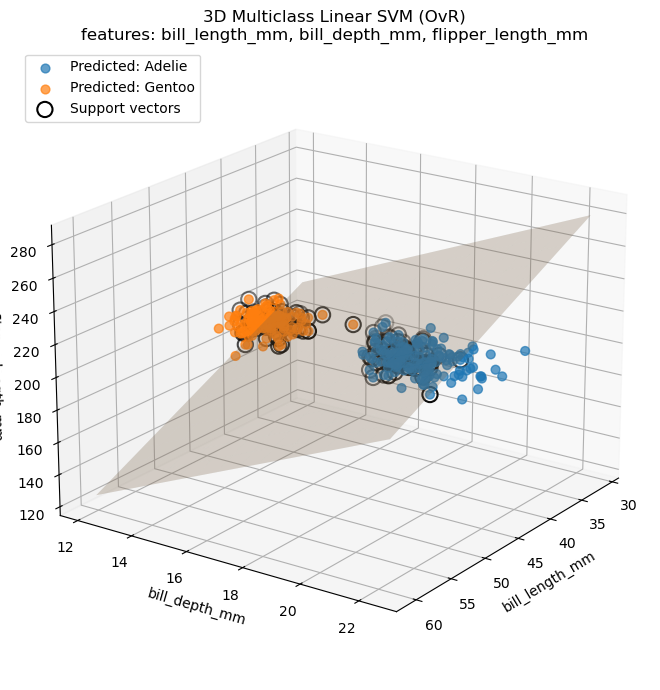

In [64]:

# ============================================
# Cell 7: 3D decision surfaces (one plane per class) + support vectors
# ============================================

planes3d = svm3d.hyperplanes_original()  # dict: class -> (w, b)
classes = svm3d.classes_
n_classes = len(classes)

f1, f2, f3 = FEATURES_3D

# 3D grid in (f1, f2) for plotting planes
x_range = np.linspace(X3[:, 0].min() - 1, X3[:, 0].max() + 1, 15)
y_range = np.linspace(X3[:, 1].min() - 1, X3[:, 1].max() + 1, 15)
xx, yy = np.meshgrid(x_range, y_range)

# Predict labels for all points to color scatter
y3_all_pred = svm3d.predict(X3)

# Some distinct colors
base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
color_map_classes = {}
for i, cls in enumerate(classes):
    color_map_classes[cls] = base_colors[i % len(base_colors)]

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# Plot data points colored by predicted class
for cls in classes:
    mask = (y3_all_pred == cls)
    ax.scatter(
        X3[mask, 0],
        X3[mask, 1],
        X3[mask, 2],
        label=f"Predicted: {cls}",
        color=color_map_classes[cls],
        alpha=0.7,
        s=40
    )

# Plot one-vs-rest planes for each class
for cls in classes:
    w, b = planes3d[cls]
    # plane: w1*x + w2*y + w3*z + b = 0  =>  z = -(b + w1*x + w2*y)/w3
    if abs(w[2]) < 1e-8:
        # skip if nearly vertical in z
        continue
    zz = (-b - w[0] * xx - w[1] * yy) / w[2]
    ax.plot_surface(
        xx, yy, zz,
        alpha=0.15,
        color=color_map_classes[cls],
        edgecolor="none"
    )

# Plot support vectors (union over all models)
sv3 = svm3d.support_vectors_
ax.scatter(
    sv3[:, 0],
    sv3[:, 1],
    sv3[:, 2],
    s=120,
    facecolors="none",
    edgecolors="black",
    linewidths=1.5,
    label="Support vectors"
)

ax.set_title(f"3D Multiclass Linear SVM (OvR)\nfeatures: {f1}, {f2}, {f3}")
ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)
ax.legend(loc="upper left")
ax.view_init(elev=20, azim=35)
plt.tight_layout()
plt.show()



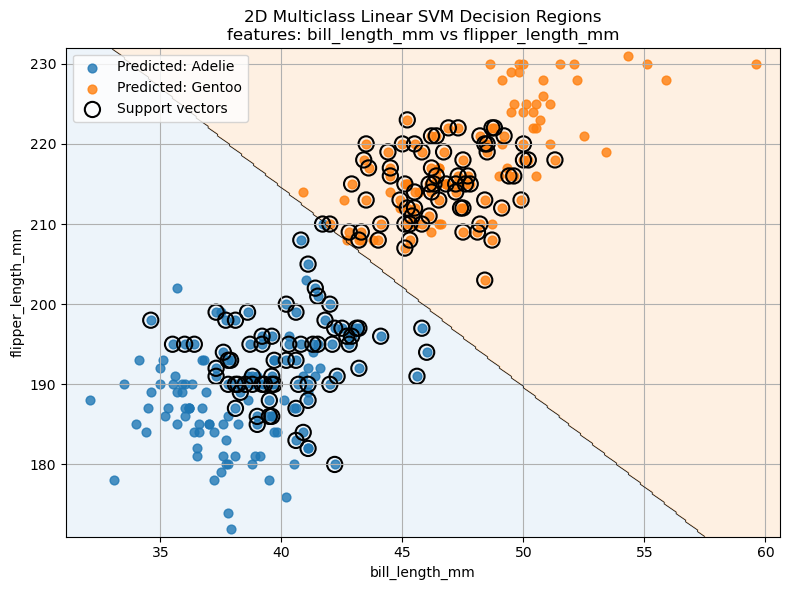

In [65]:

# ============================================
# Cell 8: 2D decision regions + boundaries + support vectors
# ============================================

g1, g2 = FEATURES_2D

# Grid for decision regions
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx2, yy2 = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_points = np.c_[xx2.ravel(), yy2.ravel()]

# Compute OvR scores and predicted classes on grid
scores_grid = svm2d.decision_function(grid_points)   # shape: (n_points, n_classes)
grid_pred_idx = np.argmax(scores_grid, axis=1)
grid_pred_labels = svm2d.classes_[grid_pred_idx]

# Map classes to integers for contourf
class_to_int = {cls: i for i, cls in enumerate(svm2d.classes_)}
Z_int = np.vectorize(class_to_int.get)(grid_pred_labels).reshape(xx2.shape)

plt.figure(figsize=(8, 6))

# Background decision regions
region_colors = ["#c6dbef", "#fdd0a2", "#c7e9c0", "#fbb4b9", "#e0ecf4"]
cmap_regions = ListedColormap(region_colors[:n_classes])
plt.contourf(xx2, yy2, Z_int, alpha=0.3, cmap=cmap_regions)

# Optional: contour lines between regions
plt.contour(xx2, yy2, Z_int, levels=np.arange(-0.5, n_classes), colors="k", linewidths=0.5)

# Plot data points colored by predicted class
y2_all_pred = svm2d.predict(X2)
for cls in classes:
    mask = (y2_all_pred == cls)
    plt.scatter(
        X2[mask, 0],
        X2[mask, 1],
        label=f"Predicted: {cls}",
        color=color_map_classes[cls],
        alpha=0.8,
        s=40
    )

# Support vectors (union)
sv2 = svm2d.support_vectors_
plt.scatter(
    sv2[:, 0],
    sv2[:, 1],
    s=120,
    facecolors="none",
    edgecolors="black",
    linewidths=1.5,
    label="Support vectors"
)

plt.title(f"2D Multiclass Linear SVM Decision Regions\nfeatures: {g1} vs {g2}")
plt.xlabel(g1)
plt.ylabel(g2)
plt.legend()
plt.tight_layout()
plt.show()
